/tmp/ipykernel_8690/4160612200.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [6]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

from torchvision import datasets, transforms


import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

/tmp/ipykernel_8799/2766341763.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [7]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data/UCMerced_LandUse/Images" #"../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "models/mercedDatasetResnet/" #"../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [8]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]) # got these number from CIFAR-10 training; not sure
])

test_transform = transforms.Compose([transforms.Resize(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])


# Create dataset
train_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform) 
val_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)
test_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)

# Get class names from original dataset 
class_names = train_dataset.classes

# Split dataset into train, val, test
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

# Set seed
pl.seed_everything(42)
train_set, _, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
pl.seed_everything(42)
_, val_set, _ = torch.utils.data.random_split(val_dataset, [train_size, val_size, test_size])
pl.seed_everything(42)
_, _, test_set = torch.utils.data.random_split(test_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)


Global seed set to 42
Global seed set to 42
Global seed set to 42


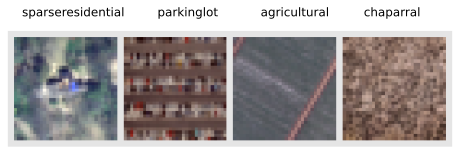

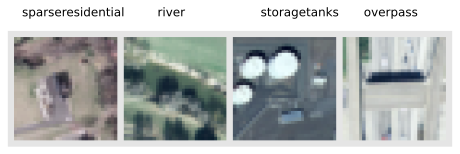

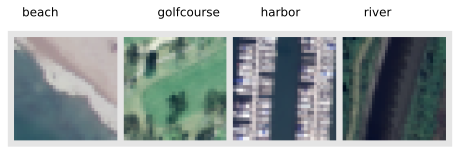

In [9]:
# Plot images along with their labels for a batch from the dataset
def plot_data(dataset, NUM_IMAGES, class_names):
    # Load images 
    UCMERCED_images = torch.stack([dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)

    # Normalize images
    img_grid = torchvision.utils.make_grid(UCMERCED_images, nrow=NUM_IMAGES, 
                                normalize=True, pad_value=0.9)

    # Permute to (H, W, C) for plotting
    img_grid = img_grid.permute(1, 2, 0) 


    plt.figure(figsize=(8,8))
    #plt.title("Image examples of the UCMERCED train dataset")
    plt.imshow(img_grid)

    max_width = 10 #max([len(x) for x in class_names]) * 8


    # Overlay class names
    for i in range(NUM_IMAGES):
        # Get class name
        cls = class_names[dataset[i][1]]
        
        # Add text
        #plt.text(i*32, 0, cls, fontsize=12, color='black') 

        # Position text 
        if i > 0:
            x = i*32 + max_width + 4 
        else:
            x = i*32 + 4


        y = -5  


        # Add text
        plt.text(x, y, cls, fontsize=12, color='black')

    plt.axis('off')
    plt.show()
    plt.close()

NUM_IMAGES= 4
plot_data(test_set, NUM_IMAGES, class_names)
plot_data(train_set, NUM_IMAGES, class_names)
plot_data(val_set, NUM_IMAGES, class_names)

In [10]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"


act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result



In [11]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

In [12]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )

        # 1x1 convolution can apply non-linearity as well, but not strictly necessary
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [13]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

In [14]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs:
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       c_hidden=c_hidden,
                                       num_blocks=num_blocks,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )

        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [15]:
model_dict["ResNet"] = ResNet

In [16]:
resnet_model, resnet_results = train_model(model_name="ResNet",
                                           model_hparams={"num_classes": 21,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"},
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: models/mercedDatasetResnet/ResNet/lightning_logs
2023-08-01 17:01:53.600050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 17:01:54.152573: W tensorflow/compiler/tf2tensorrt/utils

/home/jay/anaconda3/envs/pytutes4/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 179: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=180` reached.


Epoch 179: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 178.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 167.54it/s]


In [17]:
print("Resnet results", resnet_results)

Resnet results {'test': 0.8666666746139526, 'val': 0.8714285492897034}


In [18]:
def plot_data_predictions(images, labels, pred_classes, class_names):

  # Convert images to grid
  img_grid = torchvision.utils.make_grid(torch.from_numpy(images), nrow=images.shape[0],  
                                       normalize=True, pad_value=0.9) 

  plt.figure(figsize=(8,8))
  plt.imshow(img_grid.permute(1,2,0))

  image_width = images.shape[2] # Assuming images are squares and have shape (batch_size, channels, height, width)


  
  # Get font properties
  font = matplotlib.font_manager.FontProperties()

  # Get character width
  char_width = font.get_size() * 0.1

  # Get true and predicted labels
  lbl = class_names[labels[0]]
  p_lbl = class_names[pred_classes[0]] 
  true_width = len(lbl) * char_width
  pred_width = len(p_lbl) * char_width
  text_width_prev = max(true_width, pred_width)

  buffer_space = 1.7 # Space between images and labels

  # Loop through images and add labels
  for i in range(images.shape[0]):

    # Get true and predicted labels
    lbl = class_names[labels[i]]
    p_lbl = class_names[pred_classes[i]] 


    # Create text positions 
    # Get x position 
    if i == 0:
      x = buffer_space
    else:
      if text_width_prev > image_width:
        x = i * (image_width+buffer_space) + (text_width_prev - image_width) + buffer_space
      else:
        x = i * (image_width+buffer_space)


    if i > 0:
      # Get label widths
      true_width = len(lbl) * char_width
      pred_width = len(p_lbl) * char_width
      text_width_prev = max(true_width, pred_width)
		 
    y1 = 5
    y2 = 10

    # Add text
    plt.text(x, y1, f"{lbl}", color='blue', fontsize=12) # True label; blue
    plt.text(x, y2, f"{p_lbl}", color='red', fontsize=12) # Predicted label; red

  plt.axis('off')
  plt.show()
  plt.close()

torch.Size([4, 3, 32, 32])


True: sparseresidential
Predicted: sparseresidential
True: parkinglot
Predicted: parkinglot
True: agricultural
Predicted: runway
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


True: buildings
Predicted: buildings
True: mobilehomepark
Predicted: mobilehomepark
True: sparseresidential
Predicted: tenniscourt
True: freeway
Predicted: freeway
torch.Size([4, 3, 32, 32])


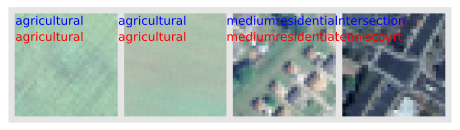

True: agricultural
Predicted: agricultural
True: agricultural
Predicted: agricultural
True: mediumresidential
Predicted: mediumresidential
True: intersection
Predicted: tenniscourt
torch.Size([4, 3, 32, 32])


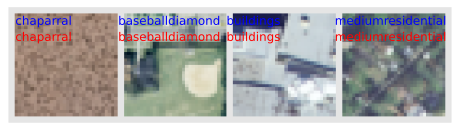

True: chaparral
Predicted: chaparral
True: baseballdiamond
Predicted: baseballdiamond
True: buildings
Predicted: buildings
True: mediumresidential
Predicted: mediumresidential
torch.Size([4, 3, 32, 32])


True: harbor
Predicted: harbor
True: harbor
Predicted: harbor
True: harbor
Predicted: harbor
True: parkinglot
Predicted: parkinglot
torch.Size([4, 3, 32, 32])


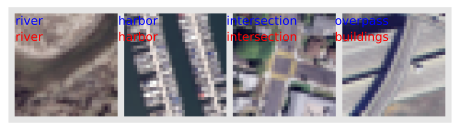

True: river
Predicted: river
True: harbor
Predicted: harbor
True: intersection
Predicted: intersection
True: overpass
Predicted: buildings
torch.Size([4, 3, 32, 32])


True: freeway
Predicted: freeway
True: baseballdiamond
Predicted: baseballdiamond
True: river
Predicted: river
True: freeway
Predicted: freeway
torch.Size([4, 3, 32, 32])


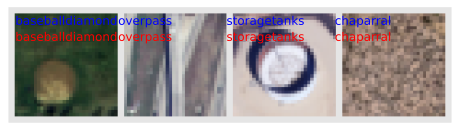

True: baseballdiamond
Predicted: baseballdiamond
True: overpass
Predicted: overpass
True: storagetanks
Predicted: storagetanks
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


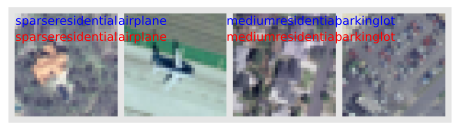

True: sparseresidential
Predicted: sparseresidential
True: airplane
Predicted: airplane
True: mediumresidential
Predicted: mediumresidential
True: parkinglot
Predicted: parkinglot
torch.Size([4, 3, 32, 32])


True: beach
Predicted: beach
True: freeway
Predicted: freeway
True: airplane
Predicted: airplane
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


True: golfcourse
Predicted: golfcourse
True: freeway
Predicted: freeway
True: river
Predicted: river
True: beach
Predicted: beach
torch.Size([4, 3, 32, 32])


True: storagetanks
Predicted: storagetanks
True: tenniscourt
Predicted: buildings
True: buildings
Predicted: buildings
True: beach
Predicted: beach
torch.Size([4, 3, 32, 32])


True: sparseresidential
Predicted: sparseresidential
True: beach
Predicted: beach
True: buildings
Predicted: sparseresidential
True: golfcourse
Predicted: river
torch.Size([4, 3, 32, 32])


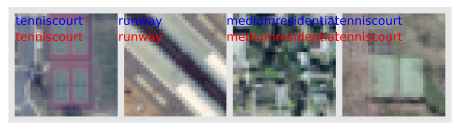

True: tenniscourt
Predicted: tenniscourt
True: runway
Predicted: runway
True: mediumresidential
Predicted: mediumresidential
True: tenniscourt
Predicted: tenniscourt
torch.Size([4, 3, 32, 32])


True: baseballdiamond
Predicted: baseballdiamond
True: buildings
Predicted: mediumresidential
True: beach
Predicted: beach
True: overpass
Predicted: overpass
torch.Size([4, 3, 32, 32])


True: golfcourse
Predicted: golfcourse
True: forest
Predicted: forest
True: denseresidential
Predicted: buildings
True: storagetanks
Predicted: storagetanks
torch.Size([4, 3, 32, 32])


True: mediumresidential
Predicted: mediumresidential
True: mobilehomepark
Predicted: mobilehomepark
True: beach
Predicted: beach
True: mediumresidential
Predicted: mediumresidential
torch.Size([4, 3, 32, 32])


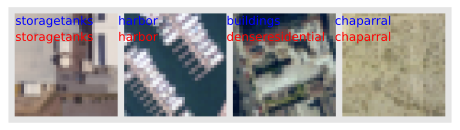

True: storagetanks
Predicted: storagetanks
True: harbor
Predicted: harbor
True: buildings
Predicted: denseresidential
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


True: baseballdiamond
Predicted: baseballdiamond
True: buildings
Predicted: buildings
True: agricultural
Predicted: agricultural
True: baseballdiamond
Predicted: baseballdiamond
torch.Size([4, 3, 32, 32])


True: tenniscourt
Predicted: storagetanks
True: parkinglot
Predicted: parkinglot
True: parkinglot
Predicted: parkinglot
True: airplane
Predicted: airplane
torch.Size([4, 3, 32, 32])


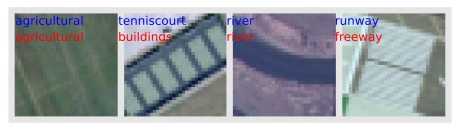

True: agricultural
Predicted: agricultural
True: tenniscourt
Predicted: buildings
True: river
Predicted: river
True: runway
Predicted: freeway
torch.Size([4, 3, 32, 32])


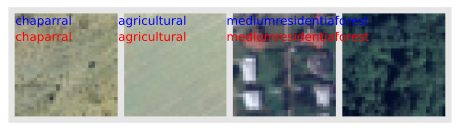

True: chaparral
Predicted: chaparral
True: agricultural
Predicted: agricultural
True: mediumresidential
Predicted: mediumresidential
True: forest
Predicted: forest
torch.Size([4, 3, 32, 32])


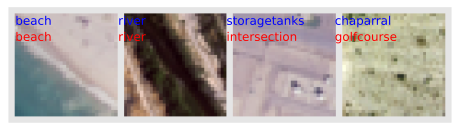

True: beach
Predicted: beach
True: river
Predicted: river
True: storagetanks
Predicted: intersection
True: chaparral
Predicted: golfcourse
torch.Size([4, 3, 32, 32])


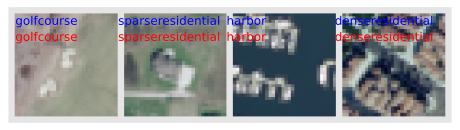

True: golfcourse
Predicted: golfcourse
True: sparseresidential
Predicted: sparseresidential
True: harbor
Predicted: harbor
True: denseresidential
Predicted: denseresidential
torch.Size([4, 3, 32, 32])


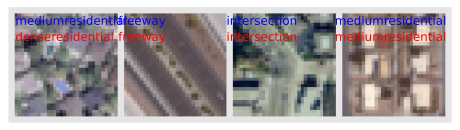

True: mediumresidential
Predicted: denseresidential
True: freeway
Predicted: freeway
True: intersection
Predicted: intersection
True: mediumresidential
Predicted: mediumresidential
torch.Size([4, 3, 32, 32])


True: tenniscourt
Predicted: tenniscourt
True: storagetanks
Predicted: storagetanks
True: runway
Predicted: runway
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


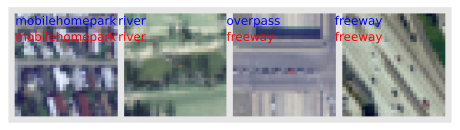

True: mobilehomepark
Predicted: mobilehomepark
True: river
Predicted: river
True: overpass
Predicted: freeway
True: freeway
Predicted: freeway
torch.Size([4, 3, 32, 32])


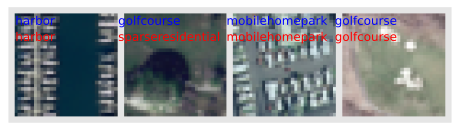

True: harbor
Predicted: harbor
True: golfcourse
Predicted: sparseresidential
True: mobilehomepark
Predicted: mobilehomepark
True: golfcourse
Predicted: golfcourse
torch.Size([4, 3, 32, 32])


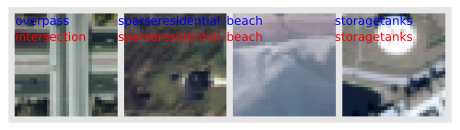

True: overpass
Predicted: intersection
True: sparseresidential
Predicted: sparseresidential
True: beach
Predicted: beach
True: storagetanks
Predicted: storagetanks
torch.Size([4, 3, 32, 32])


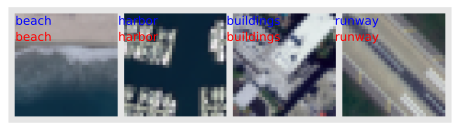

True: beach
Predicted: beach
True: harbor
Predicted: harbor
True: buildings
Predicted: buildings
True: runway
Predicted: runway
torch.Size([4, 3, 32, 32])


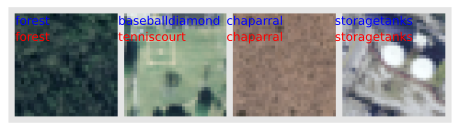

True: forest
Predicted: forest
True: baseballdiamond
Predicted: tenniscourt
True: chaparral
Predicted: chaparral
True: storagetanks
Predicted: storagetanks
torch.Size([4, 3, 32, 32])


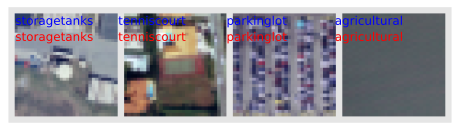

True: storagetanks
Predicted: storagetanks
True: tenniscourt
Predicted: tenniscourt
True: parkinglot
Predicted: parkinglot
True: agricultural
Predicted: agricultural
torch.Size([4, 3, 32, 32])


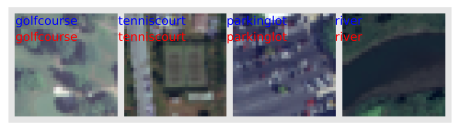

True: golfcourse
Predicted: golfcourse
True: tenniscourt
Predicted: tenniscourt
True: parkinglot
Predicted: parkinglot
True: river
Predicted: river
torch.Size([4, 3, 32, 32])


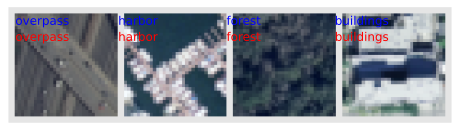

True: overpass
Predicted: overpass
True: harbor
Predicted: harbor
True: forest
Predicted: forest
True: buildings
Predicted: buildings
torch.Size([4, 3, 32, 32])


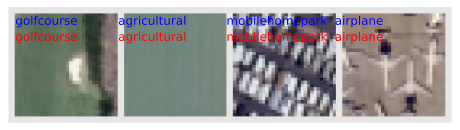

True: golfcourse
Predicted: golfcourse
True: agricultural
Predicted: agricultural
True: mobilehomepark
Predicted: mobilehomepark
True: airplane
Predicted: airplane
torch.Size([4, 3, 32, 32])


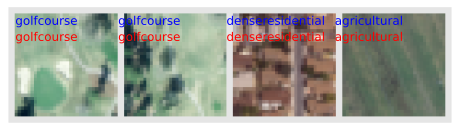

True: golfcourse
Predicted: golfcourse
True: golfcourse
Predicted: golfcourse
True: denseresidential
Predicted: denseresidential
True: agricultural
Predicted: agricultural
torch.Size([4, 3, 32, 32])


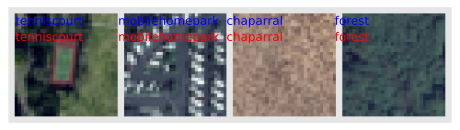

True: tenniscourt
Predicted: tenniscourt
True: mobilehomepark
Predicted: mobilehomepark
True: chaparral
Predicted: chaparral
True: forest
Predicted: forest
torch.Size([4, 3, 32, 32])


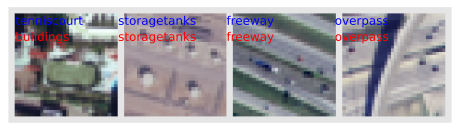

True: tenniscourt
Predicted: buildings
True: storagetanks
Predicted: storagetanks
True: freeway
Predicted: freeway
True: overpass
Predicted: overpass
torch.Size([4, 3, 32, 32])


True: forest
Predicted: forest
True: river
Predicted: river
True: beach
Predicted: beach
True: agricultural
Predicted: agricultural
torch.Size([4, 3, 32, 32])


True: agricultural
Predicted: agricultural
True: runway
Predicted: runway
True: sparseresidential
Predicted: sparseresidential
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


True: runway
Predicted: runway
True: parkinglot
Predicted: freeway
True: chaparral
Predicted: chaparral
True: denseresidential
Predicted: denseresidential
torch.Size([4, 3, 32, 32])


True: forest
Predicted: forest
True: mediumresidential
Predicted: mediumresidential
True: mobilehomepark
Predicted: mobilehomepark
True: intersection
Predicted: storagetanks
torch.Size([4, 3, 32, 32])


True: golfcourse
Predicted: baseballdiamond
True: agricultural
Predicted: agricultural
True: mobilehomepark
Predicted: mobilehomepark
True: runway
Predicted: runway
torch.Size([4, 3, 32, 32])


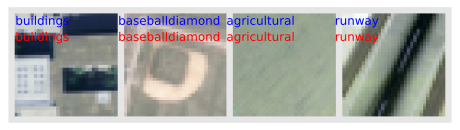

True: buildings
Predicted: buildings
True: baseballdiamond
Predicted: baseballdiamond
True: agricultural
Predicted: agricultural
True: runway
Predicted: runway
torch.Size([4, 3, 32, 32])


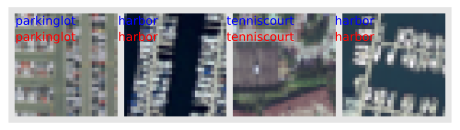

True: parkinglot
Predicted: parkinglot
True: harbor
Predicted: harbor
True: tenniscourt
Predicted: tenniscourt
True: harbor
Predicted: harbor
torch.Size([4, 3, 32, 32])


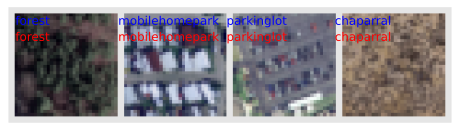

True: forest
Predicted: forest
True: mobilehomepark
Predicted: mobilehomepark
True: parkinglot
Predicted: parkinglot
True: chaparral
Predicted: chaparral
torch.Size([4, 3, 32, 32])


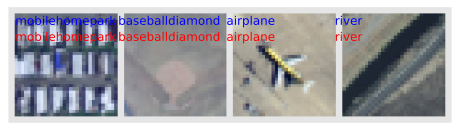

True: mobilehomepark
Predicted: mobilehomepark
True: baseballdiamond
Predicted: baseballdiamond
True: airplane
Predicted: airplane
True: river
Predicted: river
torch.Size([4, 3, 32, 32])


True: mediumresidential
Predicted: mediumresidential
True: agricultural
Predicted: agricultural
True: parkinglot
Predicted: parkinglot
True: mediumresidential
Predicted: mediumresidential
torch.Size([4, 3, 32, 32])


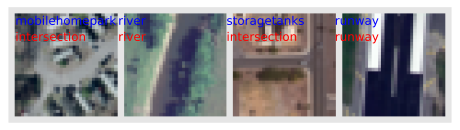

True: mobilehomepark
Predicted: intersection
True: river
Predicted: river
True: storagetanks
Predicted: intersection
True: runway
Predicted: runway
torch.Size([4, 3, 32, 32])


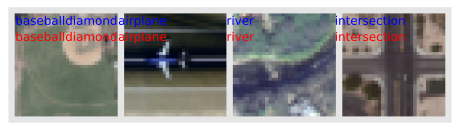

True: baseballdiamond
Predicted: baseballdiamond
True: airplane
Predicted: airplane
True: river
Predicted: river
True: intersection
Predicted: intersection
torch.Size([4, 3, 32, 32])


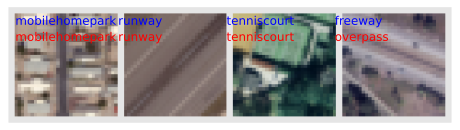

True: mobilehomepark
Predicted: mobilehomepark
True: runway
Predicted: runway
True: tenniscourt
Predicted: tenniscourt
True: freeway
Predicted: overpass
torch.Size([4, 3, 32, 32])


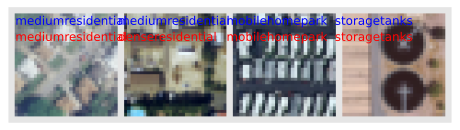

True: mediumresidential
Predicted: mediumresidential
True: mediumresidential
Predicted: denseresidential
True: mobilehomepark
Predicted: mobilehomepark
True: storagetanks
Predicted: storagetanks
torch.Size([2, 3, 32, 32])


True: chaparral
Predicted: chaparral
True: river
Predicted: river


In [23]:
# Use above model to test results and print out the results
# model = resnet_model

# Use checkpointed model:
checkpoint_path = "models/mercedDatasetResnet/ResNet/lightning_logs/version_0/checkpoints/epoch=157-step=2054.ckpt"
model = CIFARModule.load_from_checkpoint(checkpoint_path)

# Move model to GPU
model = model.to(device)

# Put model in eval mode
model.eval()
model.freeze()

test_loader_plot = data.DataLoader(test_set, batch_size=4, shuffle=False, drop_last=False, num_workers=4)


# Run model on test data
for i, (imgs, labels) in enumerate(test_loader_plot):

    imgs = imgs.to(device) # Move to GPU
    print(imgs.shape)
    #labels = labels.to(device) 

    # Make predictions
    with torch.no_grad():
        preds = model(imgs)
        pred_classes = preds.argmax(dim=-1)

    # Get images as numpy array
    imgs = imgs.cpu().numpy() 
    pred_classes = pred_classes.cpu().numpy()

    # Plot image, true and predicted label
    plot_data_predictions(imgs, labels, pred_classes, class_names)
    #plot_data(imgs, 1, class_names)
    for j in range(len(labels)):
        print("True:", class_names[labels[j]])
        print("Predicted:", class_names[pred_classes[j]])


In [24]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []

for i, (imgs, labels) in enumerate(test_loader):

  imgs = imgs.to(device)

  with torch.no_grad():
     preds = model(imgs)
     pred_classes = preds.argmax(dim=-1)
  
  all_preds.extend(pred_classes.cpu().numpy())
  all_labels.extend(labels.cpu().numpy())

# Calculate F1 score 
f1 = f1_score(all_labels, all_preds, average='macro')
print('F1 score:', f1)

F1 score: 0.8485338846415451
